# Figure 3. Mouse Dentate Gyrus as Dynamical Systems

## Package Import

In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import sklearn
import scipy
import pandas as pd
import matplotlib.pyplot as plt
scv.set_figure_params()

## Data Import

In [2]:
# Load in data
adata = scv.datasets.dentategyrus_lamanno()
adata_raw = adata.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Data Preprocessing

In [3]:
# Preprocessing
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.filter_and_normalize(adata_raw, log=False, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

# Extract dynamical velocity vectors from raw RNA counts
scv.tl.recover_dynamics(adata, n_jobs=2)
scv.tl.velocity(adata, mode='dynamical', use_raw=True)
scv.tl.velocity_graph(adata, n_jobs=2)
scv.pl.velocity_embedding_stream(adata, basis='umap')

# Latent time inference
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:15) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 2/36 cores)


  0%|          | 0/1384 [00:00<?, ?gene/s]

    finished (0:16:51) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:18) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 2/36 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:00:56) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


KeyError: 'X_umap'

In [ ]:
# Add noise to input - as denoising AEs
X = np.tile(adata_raw.X.A[:, adata.var["velocity_genes"]], (5, 1))
Y = np.tile(adata.layers["velocity"][:, adata.var["velocity_genes"]], (5, 1))
noise_sigma = (adata_raw.X.A.std()/70)**2
X[adata_raw.shape[0]:, :] += \
    np.random.normal(0, noise_sigma, X[adata_raw.shape[0]:, :].shape)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, 
                                                    Y, 
                                                    test_size=0.1, 
                                                    random_state=42)

# we see that noise has been added to denoise the autoencoder
print("Original")
print(X[:100])
print("Original + Noise")
print(X[adata.shape[0]:(adata.shape[0]+100), :])

### Model Training

In [ ]:
import tensorflow as tf
from tensorflow import keras
import scipy
from vae import create_encoder, create_decoder, VAE
tf.config.list_physical_devices('GPU')

In [ ]:
# Integrating a Variational Autoencoder (VAE) can be computationally intensive due to the sampling layer
# Because while integrating, the VAE needs to be called many times
# We tested this tutorial on a normal laptop computer to increase accessibility.
# Therefore, in this tutorial, we temporaily substituted the VAE for a normal AE.
# The results are similar if using a normal AE instead of VAE
# Alternatively, feel free to uncomment the code chunk below to use the VAE.

# encoder = create_encoder(adata.shape[1])
# decoder = create_decoder(adata.shape[1])
# autoencoder = VAE(encoder, decoder)
# opt = keras.optimizers.Adam(learning_rate=0.00001)
# autoencoder.compile(optimizer=opt)

input_dim = keras.Input(shape=(X.shape[1],))
encoded = keras.layers.Dense(64, activation="relu")(input_dim)
encoded = keras.layers.Dense(16, activation="relu")(encoded)

decoded = keras.layers.Dense(16, activation="relu")(encoded)
decoded = keras.layers.Dense(64, activation="relu")(decoded)
decoded = keras.layers.Dense(Y.shape[1])(decoded)

encoder = keras.Model(input_dim, encoded)
autoencoder = keras.Model(input_dim, decoded)

opt = keras.optimizers.Adam(learning_rate=0.00005)
autoencoder.compile(optimizer=opt, loss='mse')
autoencoder.summary()

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = autoencoder.fit(X_train, y_train,
        epochs=20,
        batch_size=2,
        shuffle=True,
        validation_data=(X_test, y_test),
        callbacks=[es])

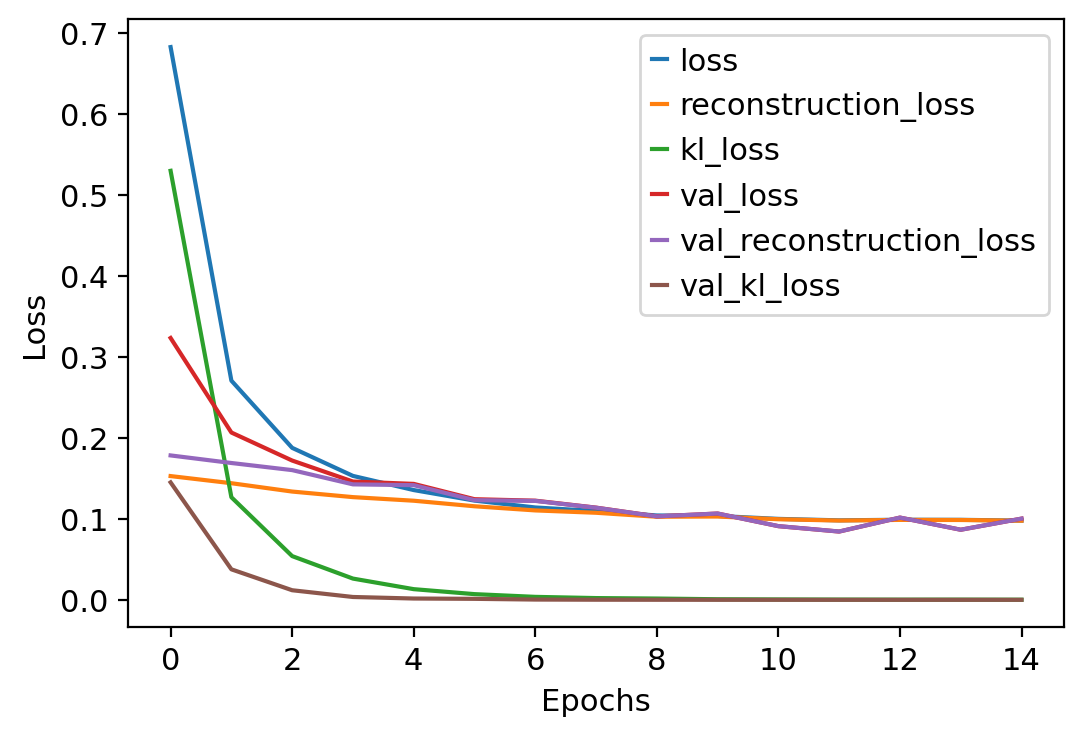

In [28]:
pd.DataFrame(history.history).plot(figsize=(6,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Visualize Sample Paths

In [ ]:
from scipy.integrate import odeint, solve_ivp
import umap
import matplotlib.pyplot as plt

In [ ]:
# PCA the count data
pca = sklearn.decomposition.PCA(n_components=30)
adata_pca = pca.fit_transform(np.log1p(adata_raw.X.A[:, adata.var["velocity_genes"]]))

# Further reduce the dim with UMAP
umap_reducer = umap.UMAP(random_state=42, n_neighbors=30, min_dist=0.25)
adata_umap = umap_reducer.fit_transform(adata_pca)

# Construct KNN with PCA
neigh = sklearn.neighbors.NearestNeighbors(n_neighbors=30)
neigh.fit(adata_pca)

In [ ]:
adata.obsm["new_umap"] = adata_umap
scv.pl.velocity_embedding_stream(adata, basis='new_umap', color="clusters", palette="tab20")

In [ ]:
#Heurstic scaling factor for the normalized magnitude when integrating
scaling_factor = np.percentile(Y.mean(axis=0) / X.mean(axis=0), 97)

#Heurstic maximum step size for the normalized magnitude when integrating
total_steps = int(np.percentile(np.abs(X.std(axis=0) * 2 / Y.mean(axis=0)), 85))
intermediate_step = 5
max_steps = total_steps // intermediate_step

print(scaling_factor, total_steps, max_steps)

In [10]:
#Heurstic scaling factor for the normalized magnitude when integrating
scaling_factor =  float(np.abs(Y).mean() / np.abs(X).mean())

#Heurstic maximum step size for the normalized magnitude when integrating
total_steps = int(np.percentile(np.abs(X.std(axis=0) * 2 / Y.mean(axis=0)), 95))
intermediate_step = 5
max_steps = total_steps // intermediate_step

print(scaling_factor, total_steps, max_steps)

0.7661044003931794 121 24


In [17]:
# ODE Solver Function
def raw_ae(t, in_x):
    input_x = tf.convert_to_tensor(np.expand_dims(in_x, axis=0))
    dx = autoencoder(np.expand_dims(y0, axis=0)).numpy().flatten() * scaling_factor
    return dx

# Interpolate over time
def interpolate(y0, neigh=neigh, pca=pca, umap_reducer=umap_reducer, steps=max_steps, intermediate_steps=intermediate_step):
    
    solution = []
    for step in range(steps):
        print(step)
        
        # Interpolate using autoencoder
        t_eval = list(range(intermediate_steps))
        #noise = np.random.normal(0, np.sqrt(adata.var["fit_variance"][adata.var["velocity_genes"]]), 
        #                          y0.shape[0])
        sol = solve_ivp(raw_ae, [0,max(t_eval)], y0, method="DOP853", t_eval=t_eval)
        y = sol.y.T
        
        # Lower dimensionality
        ending_pt_pca = pca.transform(y)
        ending_pt = umap_reducer.transform(ending_pt_pca)
        
        # Find knn reference points
        interp_neigh = neigh.kneighbors(ending_pt_pca)
        
        # New reference point
        y0 = np.median(X[interp_neigh[1][-1, :], :], axis=0)
        solution.append(y0)
        
        # Plot UMAP directions
        plt.figure(figsize=(10,3))
        plt.subplot(1, 3, 1)
        plt.scatter(adata_umap[:, 0], adata_umap[:, 1], 
                    s=1, alpha=0.5,
                    c=adata.uns["clusters_colors"][adata.obs.clusters.cat.codes.to_numpy()])
        plt.scatter(ending_pt[:, 0], 
                    ending_pt[:, 1], 
                    c=np.arange(ending_pt.shape[0]), 
                    cmap="viridis",
                    s=20
                   )
        plt.colorbar()
        plt.scatter(ending_pt[0, 0], ending_pt[0, 1], s=20, color="red")
        plt.gca().set_aspect('equal', 'datalim')
        
        # Plot PCA directions
        plt.subplot(1, 3, 2)
        plt.scatter(adata_pca[:, 0], 
                    adata_pca[:, 1], 
                    s=1, 
                    alpha=0.5, 
                    c=adata.uns["clusters_colors"][adata.obs.clusters.cat.codes.to_numpy()])
        plt.scatter(ending_pt_pca[:, 0], 
                    ending_pt_pca[:, 1], 
                    c=np.arange(ending_pt.shape[0]), 
                    cmap="viridis",
                    s=20
                   )
        plt.colorbar()
        plt.scatter(ending_pt_pca[0, 0], ending_pt_pca[0, 1], 
                    s=20, color="red")
        plt.gca().set_aspect('equal', 'datalim')

        plt.subplot(1, 3, 3)
        plt.scatter(adata_pca[:, 1], 
                    adata_pca[:, 2], 
                    s=1, 
                    alpha=0.5, c=adata.uns["clusters_colors"][adata.obs.clusters.cat.codes.to_numpy()])
        plt.scatter(ending_pt_pca[:, 1], 
                    ending_pt_pca[:, 2], 
                    c=np.arange(ending_pt.shape[0]), 
                    cmap="viridis",
                    s=20
                   )
        plt.colorbar()
        plt.scatter(ending_pt_pca[0, 1], ending_pt_pca[0, 2], 
                    s=20, color="red")
        plt.gca().set_aspect('equal', 'datalim')
        plt.show()
    
    return np.array(solution)

0


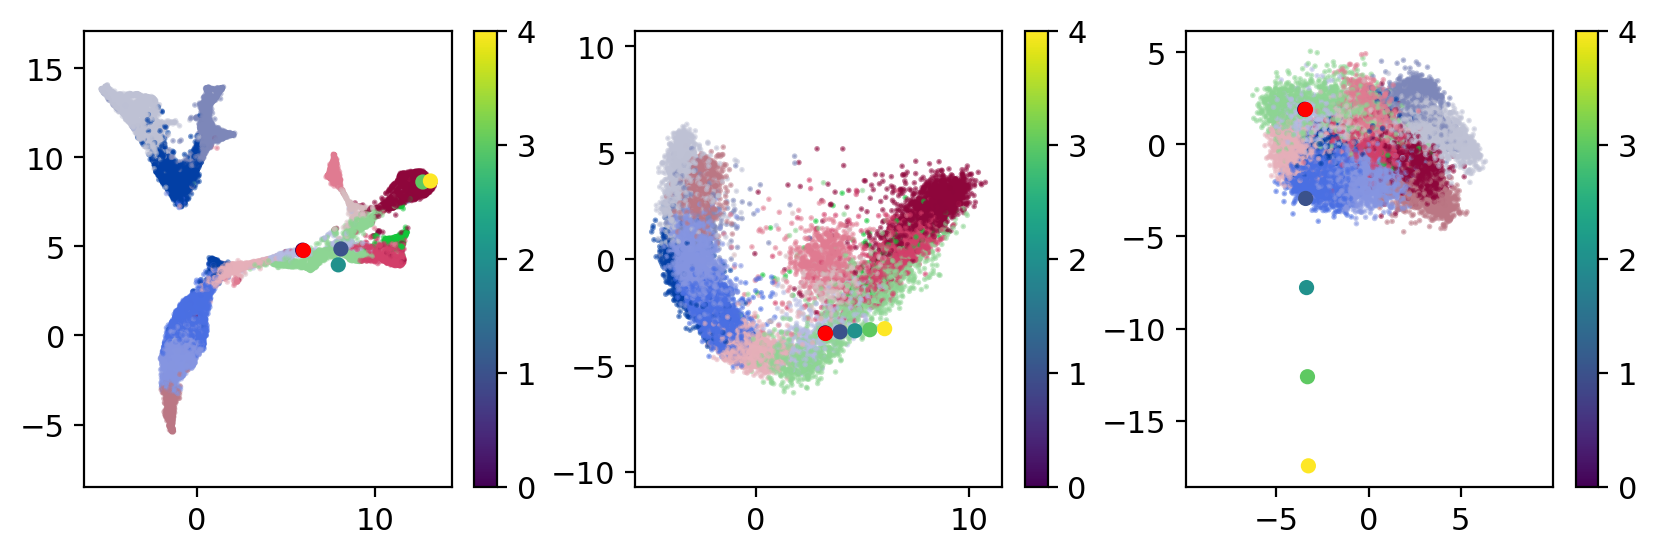

1


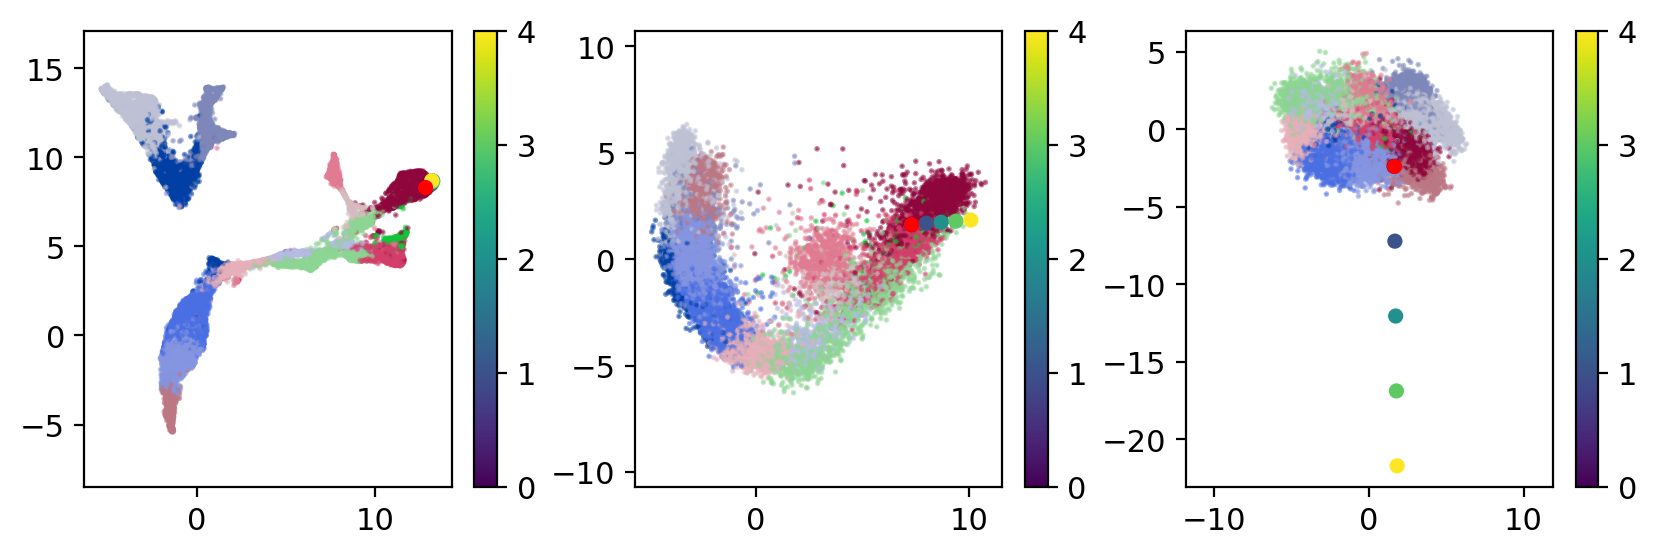

2


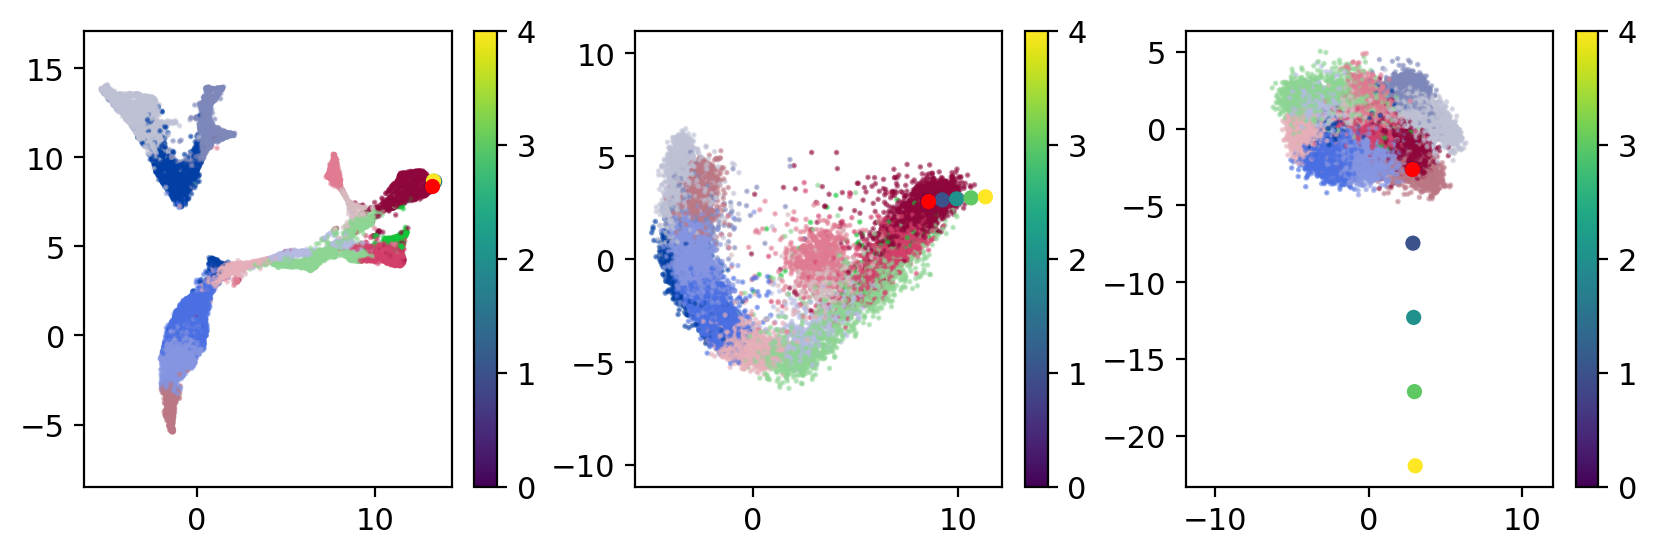

3


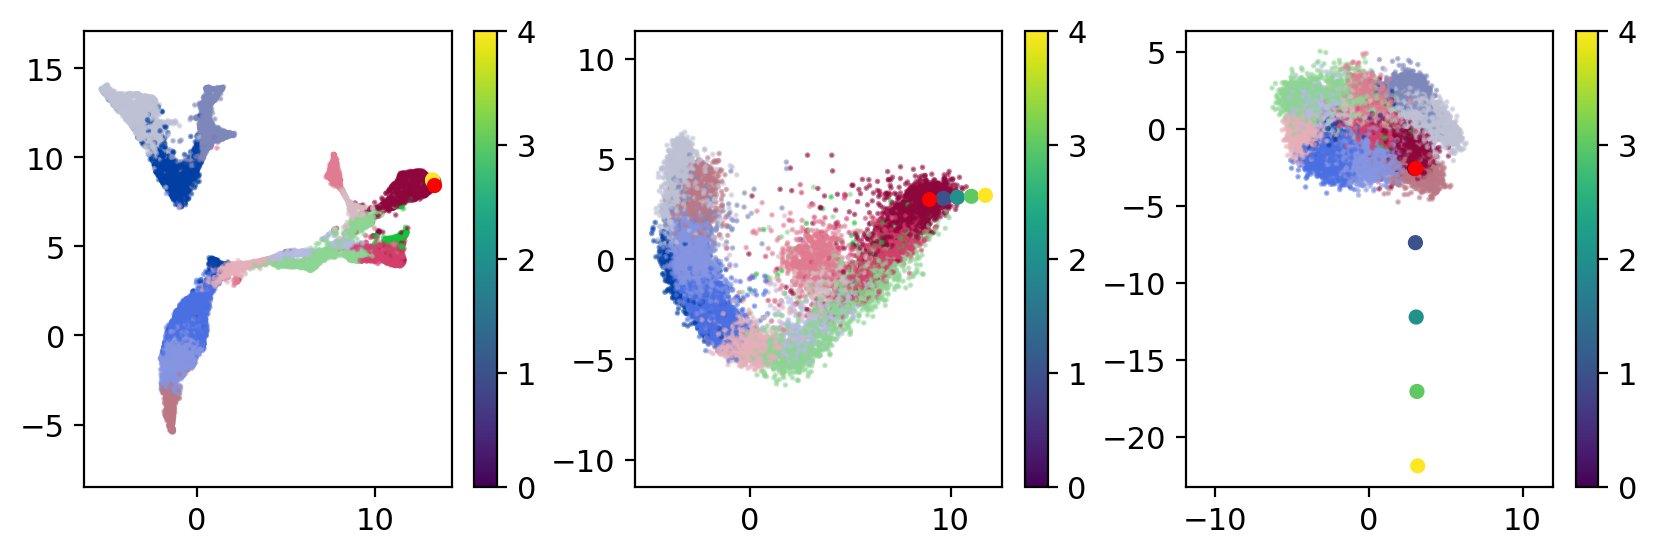

4


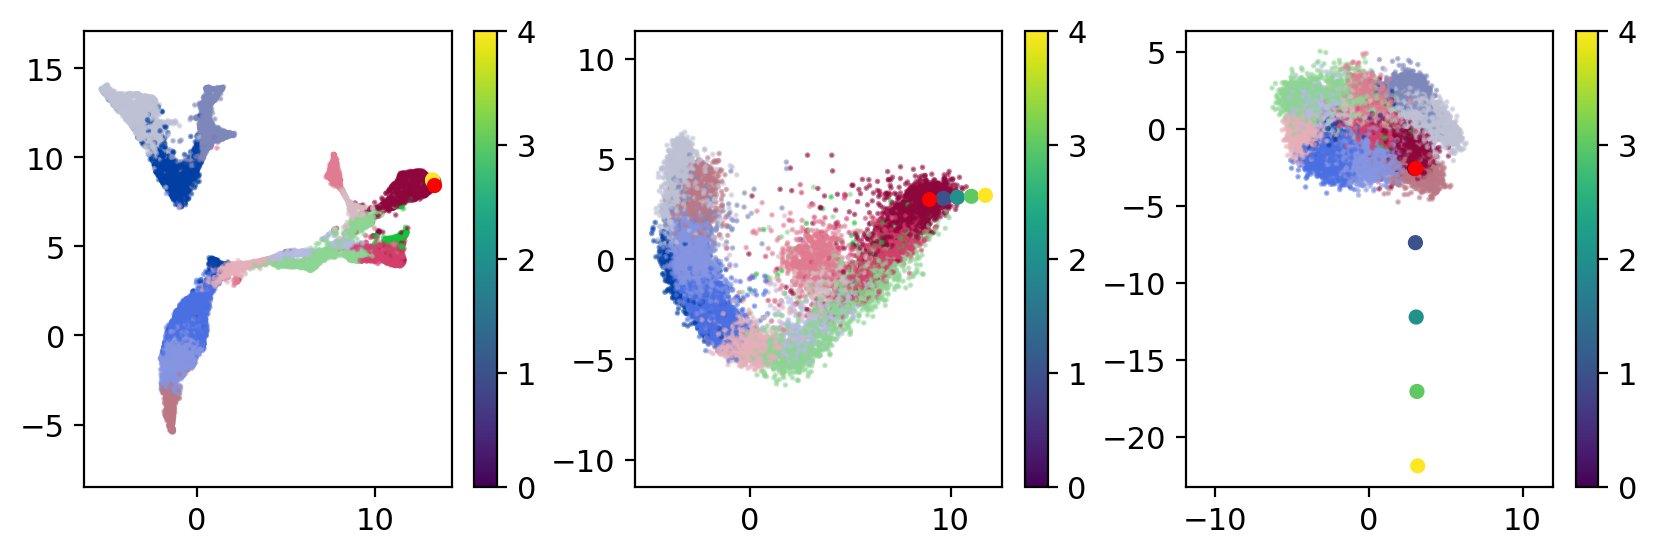

5


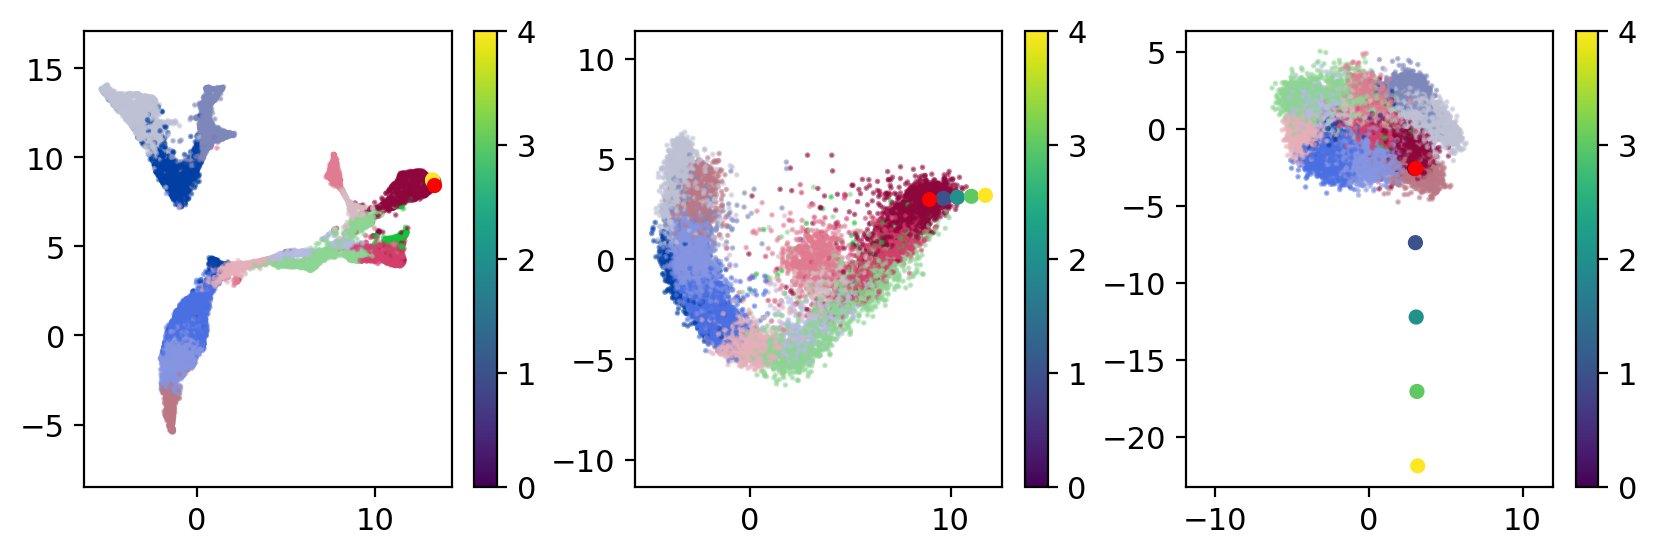

6


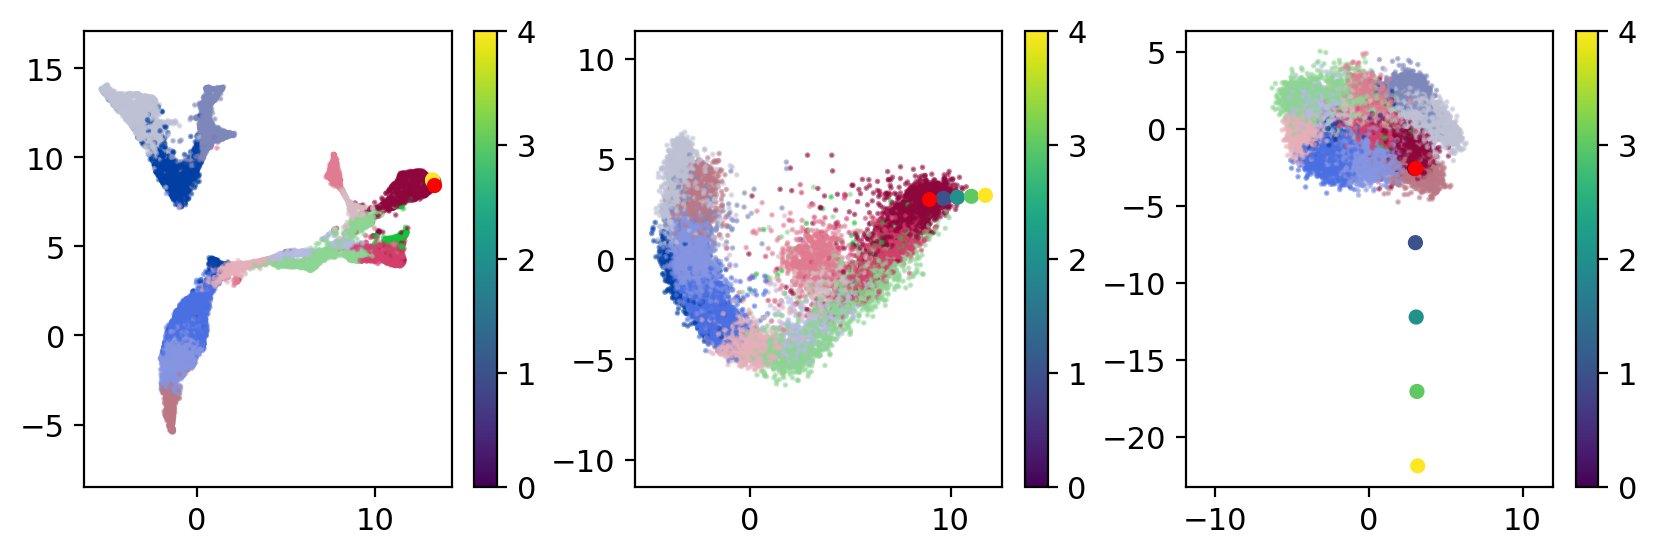

7


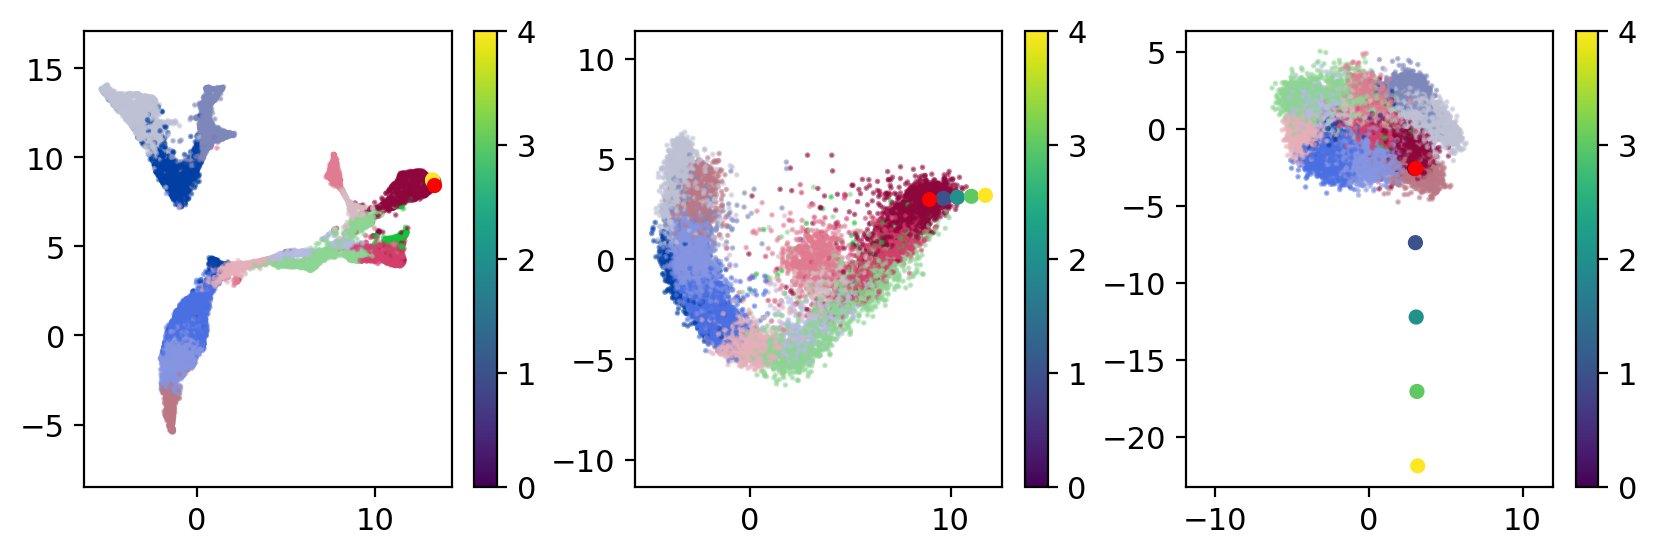

8


KeyboardInterrupt: 

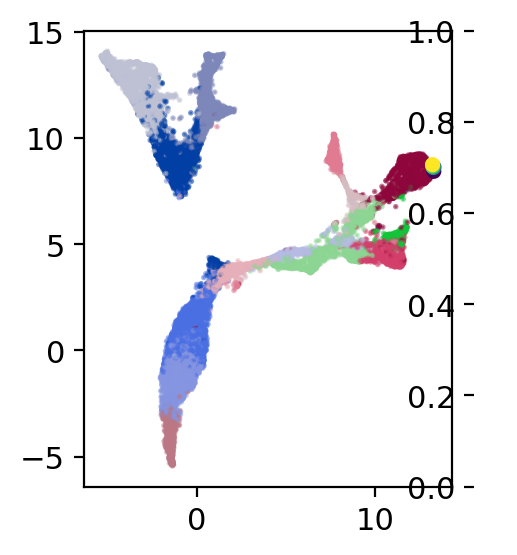

In [18]:
y0 = X[np.where(adata.obs.clusters == "Nbl1")[0][0] + adata.shape[0], :] 
y_solution = interpolate(y0, 
                         neigh = neigh, 
                         pca = pca, 
                         umap_reducer = umap_reducer, 
                         steps=max_steps)